In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import sqlalchemy
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

In [2]:
# Create connection to database
from sqlalchemy import create_engine
engine = psycopg2.connect(
    database="project4DB",
    user="postgres",
    password="postgres",
    host="fake-news-prediction-db.citnkkc6ztdk.us-east-2.rds.amazonaws.com",
    port='5432'
)

In [3]:
# Reading SQL tables into dataframes
news_df = pd.read_sql('select * from news_df', engine)
news_df.drop(['id'], axis=1, inplace=True)

# View data
news_df

,topic,news_date,label,combined_text
0,News,2017-12-31,0.0,donald trump sends out embarrassing new years...
1,News,2017-12-31,0.0,drunk bragging trump staffer started russian ...
2,News,2017-12-30,0.0,sheriff david clarke becomes an internet joke...
3,News,2017-12-29,0.0,trump is so obsessed he even has obamas name ...
4,News,2017-12-25,0.0,pope francis just called out donald trump dur...
...,...,...,...,...
44862,worldnews,2017-08-22,1.0,headless torso could belong submarine journal...
44863,worldnews,2017-08-21,1.0,north korea shipment syria chemical arm agenc...
44864,worldnews,2017-08-22,1.0,fully committed nato back new us approach afg...
44865,worldnews,2017-08-22,1.0,lexisnexis withdrew two product chinese marke...


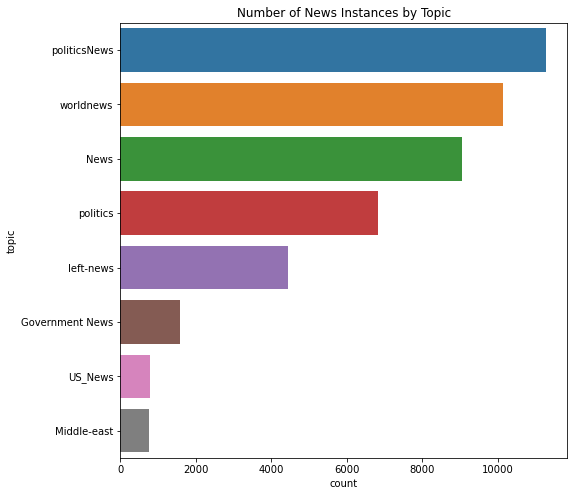

In [4]:
# Plotting number of news by topic
plt.figure(figsize = (8, 8))
sns.countplot(y = "topic", data = news_df, order = news_df['topic'].value_counts().index)
plt.title('Number of News Instances by Topic')
plt.show()

In [5]:
x_df = news_df['combined_text']
y_df = news_df['label']

# Vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which is used to find word predictions, word similarities/semantics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(x_df)
freq_term_matrix = count_vectorizer.transform(x_df)

tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

print(tf_idf_matrix)

  (0, 224319)	0.0680434987052605
  (0, 224153)	0.0833161977868531
  (0, 224008)	0.20090093440895995
  (0, 223966)	0.07279808413369786
  (0, 223038)	0.027309432739232586
  (0, 222710)	0.022995769240245698
  (0, 222093)	0.018872102012971462
  (0, 222004)	0.023488038180962116
  (0, 221853)	0.03302662264979421
  (0, 221256)	0.1640409745131494
  (0, 220282)	0.027627097922479305
  (0, 220174)	0.028043539371842056
  (0, 219840)	0.022961473292096867
  (0, 219384)	0.022445716224410616
  (0, 219373)	0.07557933831580894
  (0, 219363)	0.05236439482105218
  (0, 219143)	0.07557933831580894
  (0, 216806)	0.03379710110008687
  (0, 215816)	0.027793240033484875
  (0, 212438)	0.025555695926837017
  (0, 208503)	0.02929482980541418
  (0, 208472)	0.07872001302059041
  (0, 206820)	0.08215315181799486
  (0, 201654)	0.016255176229477364
  (0, 201498)	0.03224727261457633
  :	:
  (44866, 51861)	0.08325499300585433
  (44866, 51085)	0.08708298066685315
  (44866, 49995)	0.0393643094056153
  (44866, 49741)	0.2415611

In [6]:
# Splitting data into test and train datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, y_df, random_state = 0)

In [7]:
## Model 1 - Logistic Regression

In [8]:
# Training the model
from sklearn.linear_model import LogisticRegression
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

LogisticRegression()

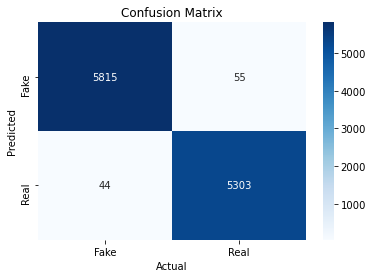

In [9]:
y_pred = model_1.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

new_cm = pd.DataFrame(cm , index = ['Fake','Real'] , columns = ['Fake','Real'])
sns.heatmap(new_cm,cmap= 'Blues', annot = True, fmt='',xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

In [10]:
model_1_name = "Logistic Regression"
model_1_accuracy = "{:.2%}".format(model_1.score(X_test, y_test))

# Print the model score
print(f"Training data score: {model_1.score(X_train, y_train)}")
print(f"Testing data score: {model_1.score(X_test, y_test)}")

Training data score: 0.9945616641901932
Testing data score: 0.9911741107247928


In [11]:
## Model 2 - Decision Tree Classifier

In [12]:
# Training the model
from sklearn import tree
model_2 = tree.DecisionTreeClassifier()
model_2.fit(X_train, y_train)

DecisionTreeClassifier()

In [13]:
model_2_name = "Decision Tree"
model_2_accuracy = "{:.2%}".format(model_2.score(X_test, y_test))

# Print the model score
print(f"Training data score: {model_2.score(X_train, y_train)}")
print(f"Testing data score: {model_2.score(X_test, y_test)}")

Training data score: 1.0
Testing data score: 0.9961665329410716


In [14]:
## Model 3 - Naive Bayes Classifier

In [15]:
# Training the model
from sklearn.naive_bayes import MultinomialNB
model_3 = MultinomialNB()
model_3.fit(X_train, y_train)

MultinomialNB()

In [16]:
model_3_name = "Naive Bayes"
model_3_accuracy = "{:.2%}".format(model_3.score(X_test, y_test))

# Print the model score
print(f"Training data score: {model_3.score(X_train, y_train)}")
print(f"Testing data score: {model_3.score(X_test, y_test)}")

Training data score: 0.9585438335809807
Testing data score: 0.9515021841847197


In [17]:
# Summary table
from tabulate import tabulate
col_names = ["Model", "Accuracy"]
table_data = [[model_1_name, model_1_accuracy],
              [model_2_name, model_2_accuracy],
              [model_3_name, model_3_accuracy]]

print(tabulate(table_data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════╤════════════╕
│ Model               │ Accuracy   │
╞═════════════════════╪════════════╡
│ Logistic Regression │ 99.12%     │
├─────────────────────┼────────────┤
│ Decision Tree       │ 99.62%     │
├─────────────────────┼────────────┤
│ Naive Bayes         │ 95.15%     │
╘═════════════════════╧════════════╛


In [18]:
## Making a prediction

In [21]:
X_new = X_test[2423]

prediction = model_1.predict(X_new)

if (prediction[0] == 0):
  print('The news in Real')
else:
  print('The news is Fake and Unreliable')

The news in Real


In [22]:
# Export machine learning model
import pickle

# Logistic Regression
filename = 'models/logistic_regression.sav'
pickle.dump(model_1, open(filename, 'wb'))

# Decision Tree
filename = 'models/decision_trees.sav'
pickle.dump(model_2, open(filename, 'wb'))

# Naive Bayes
filename = 'models/naive_bayes.sav'
pickle.dump(model_3, open(filename, 'wb'))

In [19]:
def lemmatize_sentence(text):
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk import sent_tokenize, word_tokenize

    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    sentence = ""
    
    # Tokenization
    words = nltk.word_tokenize(text)
    # Stopwords removal
    words = [w for w in words if not w in stop_words]
    # Lemmatization
    for word in words:
        sentence = sentence + ' ' + str(lemmatizer.lemmatize(word)).lower()
        
    sentence = [sentence]
        
    return sentence    

In [20]:
def vectorize_sentence(sentence):
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit_transform(sentence)
    freq_term_matrix = count_vectorizer.transform(sentence)

    tfidf = TfidfTransformer(norm = "l2")
    tfidf.fit(freq_term_matrix)
    tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)
    
    return tf_idf_matrix

In [ ]:
# Ask for user input
text = input ("Type your text: ")

In [ ]:
# Lemmatize
lemmatized_text = lemmatize_sentence(text)

# Vectorize
vectorized_text = vectorize_sentence(lemmatized_text)

In [ ]:
# Make prediction
prediction = model_1.predict(vectorized_text)

if (prediction[0] == 0):
  print('The news is Real.')
else:
  print('The news is Fake.')